In [6]:
import torchvision
import numpy as np
from torch.utils import data
from matplotlib import pyplot as plt
import torchvision.transforms.v2 as transforms
import torch
import torch.nn as nn
from torchsummary import summary
from collections import OrderedDict
import torch.nn.functional as F
from losses.centernet_ttf import CenternetTTFLoss
from training.encoder import CenternetEncoder
from utils.tmp_visualizer import get_image_with_bboxes

%load_ext autoreload
%autoreload 2

print("GPU is available: ", torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available:  False


In [54]:
input_height = input_width = 256
down_ratio = 4  # model output compared to model input

In [55]:
dataset_val = torchvision.datasets.VOCDetection(
    root="../VOC", year="2007", image_set="train", download=False
)
img, lbl = dataset_val[0]
print(img)
print(lbl)
print("+++++++++++++++++++++++++++++++++++++++++++++++")

dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)
print(len(dataset_val))

img, lbl = dataset_val[0]
img, lbl

<PIL.Image.Image image mode=RGB size=500x333 at 0x735DB03627B0>
{'annotation': {'folder': 'VOC2007', 'filename': '000012.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '207539885'}, 'owner': {'flickrid': 'KevBow', 'name': '?'}, 'size': {'width': '500', 'height': '333', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'car', 'pose': 'Rear', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}
+++++++++++++++++++++++++++++++++++++++++++++++
2501


(<PIL.Image.Image image mode=RGB size=500x333>,
 {'boxes': BoundingBoxes([[156,  97, 351, 270]], format=BoundingBoxFormat.XYXY, canvas_size=(333, 500)),
  'labels': tensor([7])})

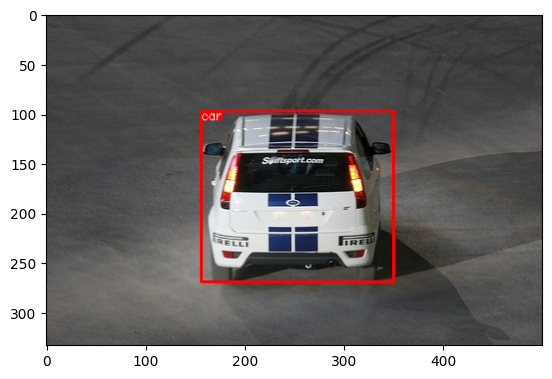

In [56]:
image_with_boxes = get_image_with_bboxes(img, lbl["boxes"], lbl["labels"])
plt.imshow(image_with_boxes)

In [57]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(size=(input_width, input_height)),
    ]
)
img, bboxes, labels = transform(img, lbl["boxes"], lbl["labels"])

down_ratio = 4


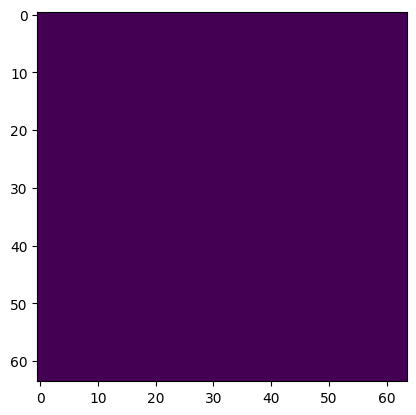

In [58]:
encoder = CenternetEncoder(input_height, input_width)
lbl_encoded = encoder(bboxes, labels)
plt.imshow(lbl_encoded[..., 8])

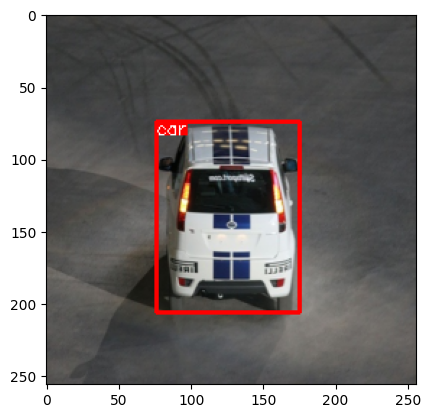

In [59]:
image_with_boxes = get_image_with_bboxes(img, bboxes, labels)
plt.imshow(image_with_boxes)

In [60]:
hm_chosen = lbl_encoded[..., 8]

ind_max = np.argwhere(hm_chosen == np.amax(hm_chosen))
for ind in ind_max:
    print("rect center:", ind * 4)
    print("coors", lbl_encoded[..., 20:][ind[0], ind[1]])
    print()

rect center: [0 0]
coors [0. 0. 0. 0.]

rect center: [0 4]
coors [0. 0. 0. 0.]

rect center: [0 8]
coors [0. 0. 0. 0.]

rect center: [ 0 12]
coors [0. 0. 0. 0.]

rect center: [ 0 16]
coors [0. 0. 0. 0.]

rect center: [ 0 20]
coors [0. 0. 0. 0.]

rect center: [ 0 24]
coors [0. 0. 0. 0.]

rect center: [ 0 28]
coors [0. 0. 0. 0.]

rect center: [ 0 32]
coors [0. 0. 0. 0.]

rect center: [ 0 36]
coors [0. 0. 0. 0.]

rect center: [ 0 40]
coors [0. 0. 0. 0.]

rect center: [ 0 44]
coors [0. 0. 0. 0.]

rect center: [ 0 48]
coors [0. 0. 0. 0.]

rect center: [ 0 52]
coors [0. 0. 0. 0.]

rect center: [ 0 56]
coors [0. 0. 0. 0.]

rect center: [ 0 60]
coors [0. 0. 0. 0.]

rect center: [ 0 64]
coors [0. 0. 0. 0.]

rect center: [ 0 68]
coors [0. 0. 0. 0.]

rect center: [ 0 72]
coors [0. 0. 0. 0.]

rect center: [ 0 76]
coors [0. 0. 0. 0.]

rect center: [ 0 80]
coors [0. 0. 0. 0.]

rect center: [ 0 84]
coors [0. 0. 0. 0.]

rect center: [ 0 88]
coors [0. 0. 0. 0.]

rect center: [ 0 92]
coors [0. 0. 0. 0.]

In [61]:
from torch.utils import data


class Dataset(data.Dataset):
    def __init__(self, dataset, transformation, encoder):
        self._dataset = dataset
        self._transformation = transformation
        self._encoder = encoder

    def __getitem__(self, index):
        img, lbl = self._dataset[index]
        img_, bboxes_, labels_ = self._transformation(img, lbl["boxes"], lbl["labels"])
        lbl_encoded = self._encoder(bboxes_, labels_)
        return img_, torch.from_numpy(lbl_encoded)

    def __len__(self):
        return len(self._dataset)


encoder = CenternetEncoder(input_height, input_width)
transform = transforms.Compose(
    [transforms.Resize(size=(input_width, input_height)), transforms.ToTensor()]
)
torch_dataset = Dataset(dataset=dataset_val, transformation=transform, encoder=encoder)

# subset_indices = torch.randperm(len(torch_dataset))[:10]
subset_indices = range(10)
torch_dataset_new = torch.utils.data.Subset(torch_dataset, subset_indices)

down_ratio = 4


/home/odysseus/VIRTUALENVS/pytorch_no_cuda/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [62]:
img_, lbl_encoded = torch_dataset_new[0]
img_.shape, lbl_encoded.shape

(torch.Size([3, 256, 256]), torch.Size([64, 64, 24]))

In [63]:
print(torch_dataset_new)

batch_generator = torch.utils.data.DataLoader(
    torch_dataset_new, batch_size=24, num_workers=4, shuffle=True
)

In [64]:
input, gt_data = next(iter(batch_generator))
torch.min(input), torch.max(input)

(tensor(0.), tensor(1.))

In [65]:
input.shape

torch.Size([10, 3, 256, 256])

In [66]:
gt_data.shape

torch.Size([10, 64, 64, 24])

In [67]:
input[0].data.numpy()

array([[[0.93333334, 0.72156864, 0.7372549 , ..., 0.6627451 ,
         0.6784314 , 0.7058824 ],
        [0.87058824, 0.7921569 , 0.90588236, ..., 0.63529414,
         0.6509804 , 0.68235296],
        [0.9411765 , 0.94509804, 0.9607843 , ..., 0.60784316,
         0.6431373 , 0.67058825],
        ...,
        [0.69803923, 0.4862745 , 0.24313726, ..., 0.7882353 ,
         0.75686276, 0.88235295],
        [0.2901961 , 0.20784314, 0.36078432, ..., 0.65882355,
         0.7882353 , 0.9098039 ],
        [0.53333336, 0.6117647 , 0.5372549 , ..., 0.654902  ,
         0.7490196 , 0.9647059 ]],

       [[0.9647059 , 0.75686276, 0.7647059 , ..., 0.65882355,
         0.6784314 , 0.7058824 ],
        [0.88235295, 0.8117647 , 0.92156863, ..., 0.6313726 ,
         0.6509804 , 0.68235296],
        [0.9411765 , 0.94509804, 0.9647059 , ..., 0.60784316,
         0.6431373 , 0.67058825],
        ...,
        [0.6666667 , 0.45882353, 0.21176471, ..., 0.7411765 ,
         0.7137255 , 0.8509804 ],
        [0.2

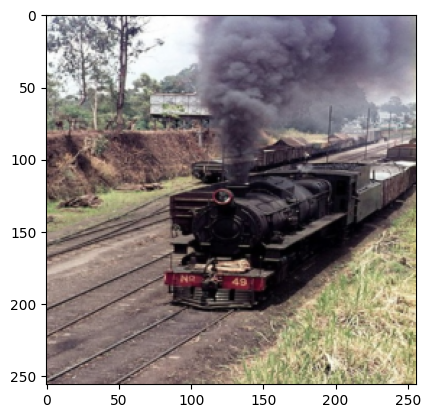

In [68]:
plt.imshow(input[0].data.numpy().transpose(1, 2, 0))

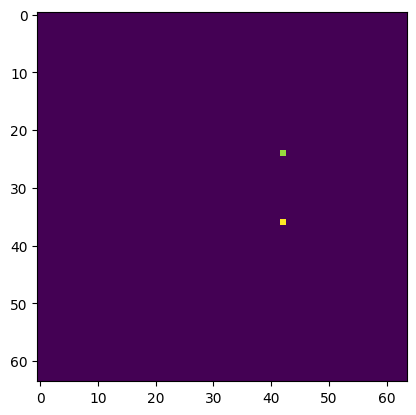

In [69]:
plt.imshow(gt_data[0].data.numpy().sum(axis=2))

In [70]:
class Backbone(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.block_num = 1
        self.alpha = alpha
        self.filters = np.array(
            [
                64 * self.alpha,
                128 * self.alpha,
                256 * self.alpha,
                512 * self.alpha,
                512 * self.alpha,
            ]
        ).astype("int")
        s = self.filters
        self.layer1 = self.conv_bn_relu(3, s[0], False)
        self.layer2 = self.conv_bn_relu(s[0], s[0], True)  # stride 2
        self.layer3 = self.conv_bn_relu(s[0], s[1], False)
        self.layer4 = self.conv_bn_relu(s[1], s[1], True)  # stride 4
        self.layer5 = self.conv_bn_relu(s[1], s[2], False)
        self.layer6 = self.conv_bn_relu(s[2], s[2], False)
        self.layer7 = self.conv_bn_relu(s[2], s[2], True)  # stride 8
        self.layer8 = self.conv_bn_relu(s[2], s[3], False)
        self.layer9 = self.conv_bn_relu(s[3], s[3], False)
        self.layer10 = self.conv_bn_relu(s[3], s[3], True)  # stride 16
        self.layer11 = self.conv_bn_relu(s[4], s[4], False)
        self.layer12 = self.conv_bn_relu(s[4], s[4], False)
        self.layer13 = self.conv_bn_relu(s[4], s[4], True)  # stride 32

    def conv_bn_relu(self, input_num, output_num, max_pool=False, kernel_size=3):
        block = OrderedDict()
        block["conv_" + str(self.block_num)] = nn.Conv2d(
            input_num, output_num, kernel_size=kernel_size, stride=1, padding=1
        )
        block["bn_" + str(self.block_num)] = nn.BatchNorm2d(
            output_num, eps=1e-3, momentum=0.01
        )
        block["relu_" + str(self.block_num)] = nn.ReLU()
        if max_pool:
            block["pool_" + str(self.block_num)] = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block_num += 1
        return nn.Sequential(block)

    def forward(self, x):
        out = self.layer1(x)
        out_stride_2 = self.layer2(out)
        out = self.layer3(out_stride_2)
        out_stride_4 = self.layer4(out)
        out = self.layer5(out_stride_4)
        out = self.layer6(out)
        out_stride_8 = self.layer7(out)
        out = self.layer8(out_stride_8)
        out = self.layer9(out)
        out_stride_16 = self.layer10(out)
        out = self.layer11(out_stride_16)
        out = self.layer12(out)
        out_stride_32 = self.layer13(out)
        return out_stride_2, out_stride_4, out_stride_8, out_stride_16, out_stride_32

In [71]:
class Head(nn.Module):
    def __init__(self, backbone_output_filters, class_number=20):
        super().__init__()
        self.connection_num = 3
        self.class_number = class_number
        self.backbone_output_filters = backbone_output_filters
        self.filters = [128, 64, 32]
        head_filters = [self.backbone_output_filters[-1]] + self.filters

        for i, filter_num in enumerate(self.filters):
            name = f"head_{i+1}"
            setattr(
                self,
                name,
                self.conv_bn_relu(name, head_filters[i], head_filters[i + 1]),
            )
            # create connection with backbone
            if i < self.connection_num:
                name = f"after_{-2-i}"
                setattr(
                    self,
                    name,
                    self.conv_bn_relu(
                        name, self.backbone_output_filters[-2 - i], self.filters[i], 1
                    ),
                )

        self.before_hm = self.conv_bn_relu(
            "before_hm", self.filters[-1], self.filters[-1]
        )
        self.before_sizes = self.conv_bn_relu(
            "before_sizes", self.filters[-1], self.filters[-1]
        )

        self.hm = self.conv_bn_relu(
            "hm", self.filters[-1], self.class_number, 3, "sigmoid"
        )
        self.sizes = self.conv_bn_relu("hm", self.filters[-1], 4, 3, None)

    def conv_bn_relu(
        self, name, input_num, output_num, kernel_size=3, activation="relu"
    ):
        block = OrderedDict()
        padding = 1 if kernel_size == 3 else 0
        block["conv_" + name] = nn.Conv2d(
            input_num, output_num, kernel_size=kernel_size, stride=1, padding=padding
        )
        block["bn_" + name] = nn.BatchNorm2d(output_num, eps=1e-3, momentum=0.01)
        if activation == "relu":
            block["relu_" + name] = nn.ReLU()
        elif activation == "sigmoid":
            block["sigmoid_" + name] = nn.Sigmoid()
        return nn.Sequential(block)

    def connect_with_backbone(self, *backbone_out):
        used_out = [backbone_out[-i - 2] for i in range(self.connection_num)]
        x = backbone_out[-1]
        for i in range(len(self.filters)):
            x = getattr(self, "head_{}".format(i + 1))(x)
            x = F.interpolate(x, scale_factor=2, mode="nearest")
            if i < self.connection_num:
                name = f"after_{-2-i}"
                x_ = getattr(self, name)(used_out[i])
                x = torch.add(x, x_)
        return x

    def forward(self, *backbone_out):
        self.last_shared_layer = self.connect_with_backbone(self, *backbone_out)
        x = self.before_hm(self.last_shared_layer)
        hm_out = self.hm(x)

        x = self.before_sizes(self.last_shared_layer)
        sizes_out = self.sizes(x)

        x = torch.cat((hm_out, sizes_out), dim=1)
        return x

In [72]:
class ModelBuilder(nn.Module):
    """
    To connect head with backbone
    """

    def __init__(self, alpha=1.0, class_number=20):
        super().__init__()
        self.class_number = class_number
        self.backbone = Backbone(alpha)
        self.head = Head(
            backbone_output_filters=self.backbone.filters, class_number=class_number
        )
        self.loss = CenternetTTFLoss(
            class_number, 4, input_height // 4, input_width // 4
        )

    def forward(self, x, gt=None):
        x = x / 0.5 - 1.0  # normalization
        out = self.backbone(x)
        pred = self.head(*out)

        if gt is None:
            return pred
        else:
            loss = self.loss(gt, pred)
            return loss

In [73]:
torch.cuda.is_available()

False

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelBuilder(alpha=0.25).to(device)
# summary(model, input_size=(3, 256, 256), batch_size=-1)

loss_dict = {}


In [80]:
lr = 0.03
parameters = list(model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

model.eval()
model.train(True)

ModelBuilder(
  (backbone): Backbone(
    (layer1): Sequential(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_1): ReLU()
    )
    (layer2): Sequential(
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_2): ReLU()
      (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_3): ReLU()
    )
    (layer4): Sequential(
      (conv_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_4): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True,

In [81]:
# tensor([ 955, 1025,  219,   66, 1344,  222,  865, 2317,   86, 1409])

In [82]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch + 1))
    for _, data in enumerate(batch_generator):
        input, gt_data = data
        input = input.to(device).contiguous()

        gt_data = gt_data.to(device)
        gt_data.requires_grad = False

        loss_dict = model(input, gt=gt_data)
        optimizer.zero_grad()  # compute gradient and do optimize step
        loss_dict["loss"].backward()

        optimizer.step()

        print(loss_dict["loss"])

EPOCH 1:
tensor(11.2549, grad_fn=<AddBackward0>)
EPOCH 2:
tensor(14.3587, grad_fn=<AddBackward0>)
EPOCH 3:
tensor(13.5734, grad_fn=<AddBackward0>)
EPOCH 4:
tensor(12.7663, grad_fn=<AddBackward0>)
EPOCH 5:
tensor(11.7133, grad_fn=<AddBackward0>)
EPOCH 6:
tensor(10.9510, grad_fn=<AddBackward0>)
EPOCH 7:
tensor(10.1111, grad_fn=<AddBackward0>)
EPOCH 8:
tensor(9.5310, grad_fn=<AddBackward0>)
EPOCH 9:
tensor(9.0433, grad_fn=<AddBackward0>)
EPOCH 10:
tensor(8.4825, grad_fn=<AddBackward0>)
EPOCH 11:
tensor(8.1161, grad_fn=<AddBackward0>)
EPOCH 12:
tensor(7.6166, grad_fn=<AddBackward0>)
EPOCH 13:
tensor(7.4084, grad_fn=<AddBackward0>)
EPOCH 14:
tensor(7.1202, grad_fn=<AddBackward0>)
EPOCH 15:
tensor(6.8023, grad_fn=<AddBackward0>)
EPOCH 16:
tensor(6.4948, grad_fn=<AddBackward0>)
EPOCH 17:
tensor(6.3339, grad_fn=<AddBackward0>)
EPOCH 18:
tensor(6.1009, grad_fn=<AddBackward0>)
EPOCH 19:
tensor(5.9166, grad_fn=<AddBackward0>)
EPOCH 20:
tensor(5.5563, grad_fn=<AddBackward0>)
EPOCH 21:
tensor(5.439

In [83]:
torch.save(
    model.state_dict(),
    "../models/checkpoints/tmp_trained_model_test.pt",
)

In [53]:
model.load_state_dict(
    # torch.load("../models/checkpoints/tmp_pretrained_weights.pt", weights_only=True)
    torch.load("../models/checkpoints/tmp_trained_model_test.pt", weights_only=True)
)

model.train(True)


for _, data in enumerate(batch_generator):
    input, gt_data = data
    input = input.to(device).contiguous()

    gt_data = gt_data.to(device)
    gt_data.requires_grad = False

    loss_dict = model(input, gt=gt_data)
    loss_dict['loss'].backward()

    print(loss_dict['loss'])



tensor(8.2891, grad_fn=<AddBackward0>)


In [299]:
subset_indices

tensor([ 955, 1025,  219,   66, 1344,  222,  865, 2317,   86, 1409])

In [ ]:
img, lbl = dataset_val[0]

In [ ]:
# model.load_state_dict(torch.load("/home/odysseus/ANDRIY/Andriy_Work/PROJECTS/object_detection/tmp_OD_from_scratch/trained_model"))

tensor(955)


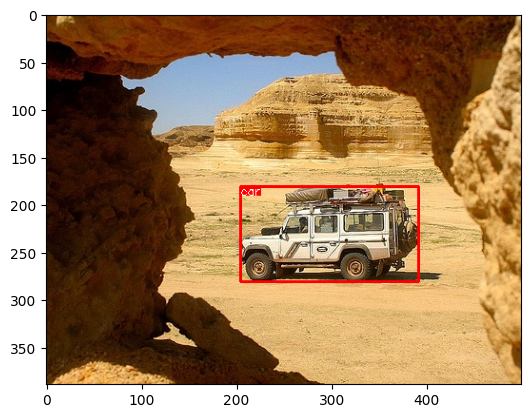

In [364]:
print(subset_indices[0])

img, lbl = dataset_val[subset_indices[0]]
# img, lbl = dataset_val[0]

# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(p=0.5), transforms.Resize(size=(input_width, input_height))])
# img, bboxes, labels = transform(img, lbl['boxes'], lbl['labels'])

image_with_boxes = get_image_with_bboxes(img, lbl["boxes"], lbl["labels"])
plt.imshow(image_with_boxes)

In [371]:
lbl

class_number = lbl["labels"].item() - 1

down_ratio = 4


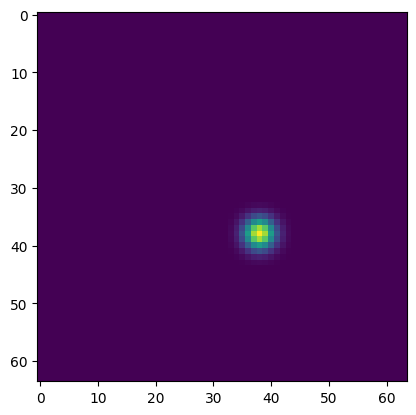

In [372]:
transform = transforms.Compose([transforms.Resize(size=(input_width, input_height))])
img, bboxes, labels = transform(img, lbl["boxes"], lbl["labels"])
encoder = CenternetEncoder(input_height, input_width)
# lbl_encoded = encoder(lbl['boxes'], lbl['labels'])
lbl_encoded = encoder(bboxes, labels)
plt.imshow(lbl_encoded[..., class_number])

In [327]:
lbl["labels"].var

<function Tensor.var>

In [22]:
subset_indices = torch.tensor([955, 1025, 219, 66, 1344, 222, 865, 2317, 86, 1409])

In [23]:
subset_indices

tensor([ 955, 1025,  219,   66, 1344,  222,  865, 2317,   86, 1409])